### **This notebook preprocesses features for the segmentation models**

In [20]:
import importlib

import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler

load_dotenv(override=True)

from customer_segmentation.constants import feature_groups as fg_const
from customer_segmentation.utils import db_utils, file_io, plot_utils, preprocessing

modules_to_reload = [file_io, preprocessing, plot_utils, db_utils, fg_const]
for module in modules_to_reload:
    importlib.reload(module)


# Set pandas to display all columns
pd.set_option("display.max_columns", None)

**Load data from local db**

In [2]:
cohort = db_utils.read_from_db_to_df("customer_cohort_model_local", db_mode="local")

In [3]:
cohort.shape

(187268, 35)

**convert data & seperate binary and numeric values**

In [4]:
cohort["min_signup_date"] = pd.to_datetime(cohort["min_signup_date"])
cohort["user_id"] = cohort["user_id"].astype(str)
binary_cols = preprocessing.get_binary_columns(cohort)
numeric_cols = (
    cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols).to_list()
)

**Load feature groups relevant for the model**

In [5]:
feature_groups = fg_const.FEATURE_GROUPS
feature_groups

{'flight_discount_score': ['avg_flight_discount',
  'flight_discount_rate',
  'discount_per_km'],
 'hotel_discount_score': ['avg_hotel_discount', 'hotel_discount_rate'],
 'user_score': ['age', 'is_married', 'has_children'],
 'engagement_score': ['days_last_trip',
  'sessions_per_month',
  'avg_session_duration_seconds',
  'page_click_per_session'],
 'flight_travel_score': ['avg_flight_travel_days',
  'avg_seats',
  'avg_checked_bags',
  'avg_distance_km',
  'flight_booked',
  'flight_booking_value'],
 'hotel_travel_score': ['avg_rooms',
  'avg_hotel_nights',
  'hotel_booked',
  'hotel_booking_value'],
 'cancellation_score': ['cancellation_rate']}

In [6]:
# extract features from dict
features = [item for items in feature_groups.values() for item in items]

### **Log-transform features**

**check features of skewness**

In [7]:
skewness = cohort[features].skew(numeric_only=True)
highly_skewed = skewness[np.abs(skewness) > 0.75].index.to_list()

highly_skewed

['avg_flight_discount',
 'flight_discount_rate',
 'discount_per_km',
 'avg_hotel_discount',
 'hotel_discount_rate',
 'days_last_trip',
 'sessions_per_month',
 'avg_session_duration_seconds',
 'page_click_per_session',
 'avg_flight_travel_days',
 'avg_seats',
 'avg_checked_bags',
 'avg_distance_km',
 'flight_booking_value',
 'avg_hotel_nights',
 'hotel_booking_value',
 'cancellation_rate']

In [8]:
# log_names -> for log-transformed features
# feature_names -> for plotting
log_names = [item + "_log" for item in highly_skewed]
feature_names = [item for item in features if item in highly_skewed]
len(log_names), len(feature_names)

(17, 17)

**Log-transform skewed features using `log1p` (handles 0 values)**

In [9]:
for log_name, feat_name in zip(log_names, feature_names):
    X_log = np.log1p(cohort[feat_name])
    cohort[log_name] = X_log

**Explore log-transformed features**  
- especially metrics with a wide range of values (long tails) are compressed to a smaller scale

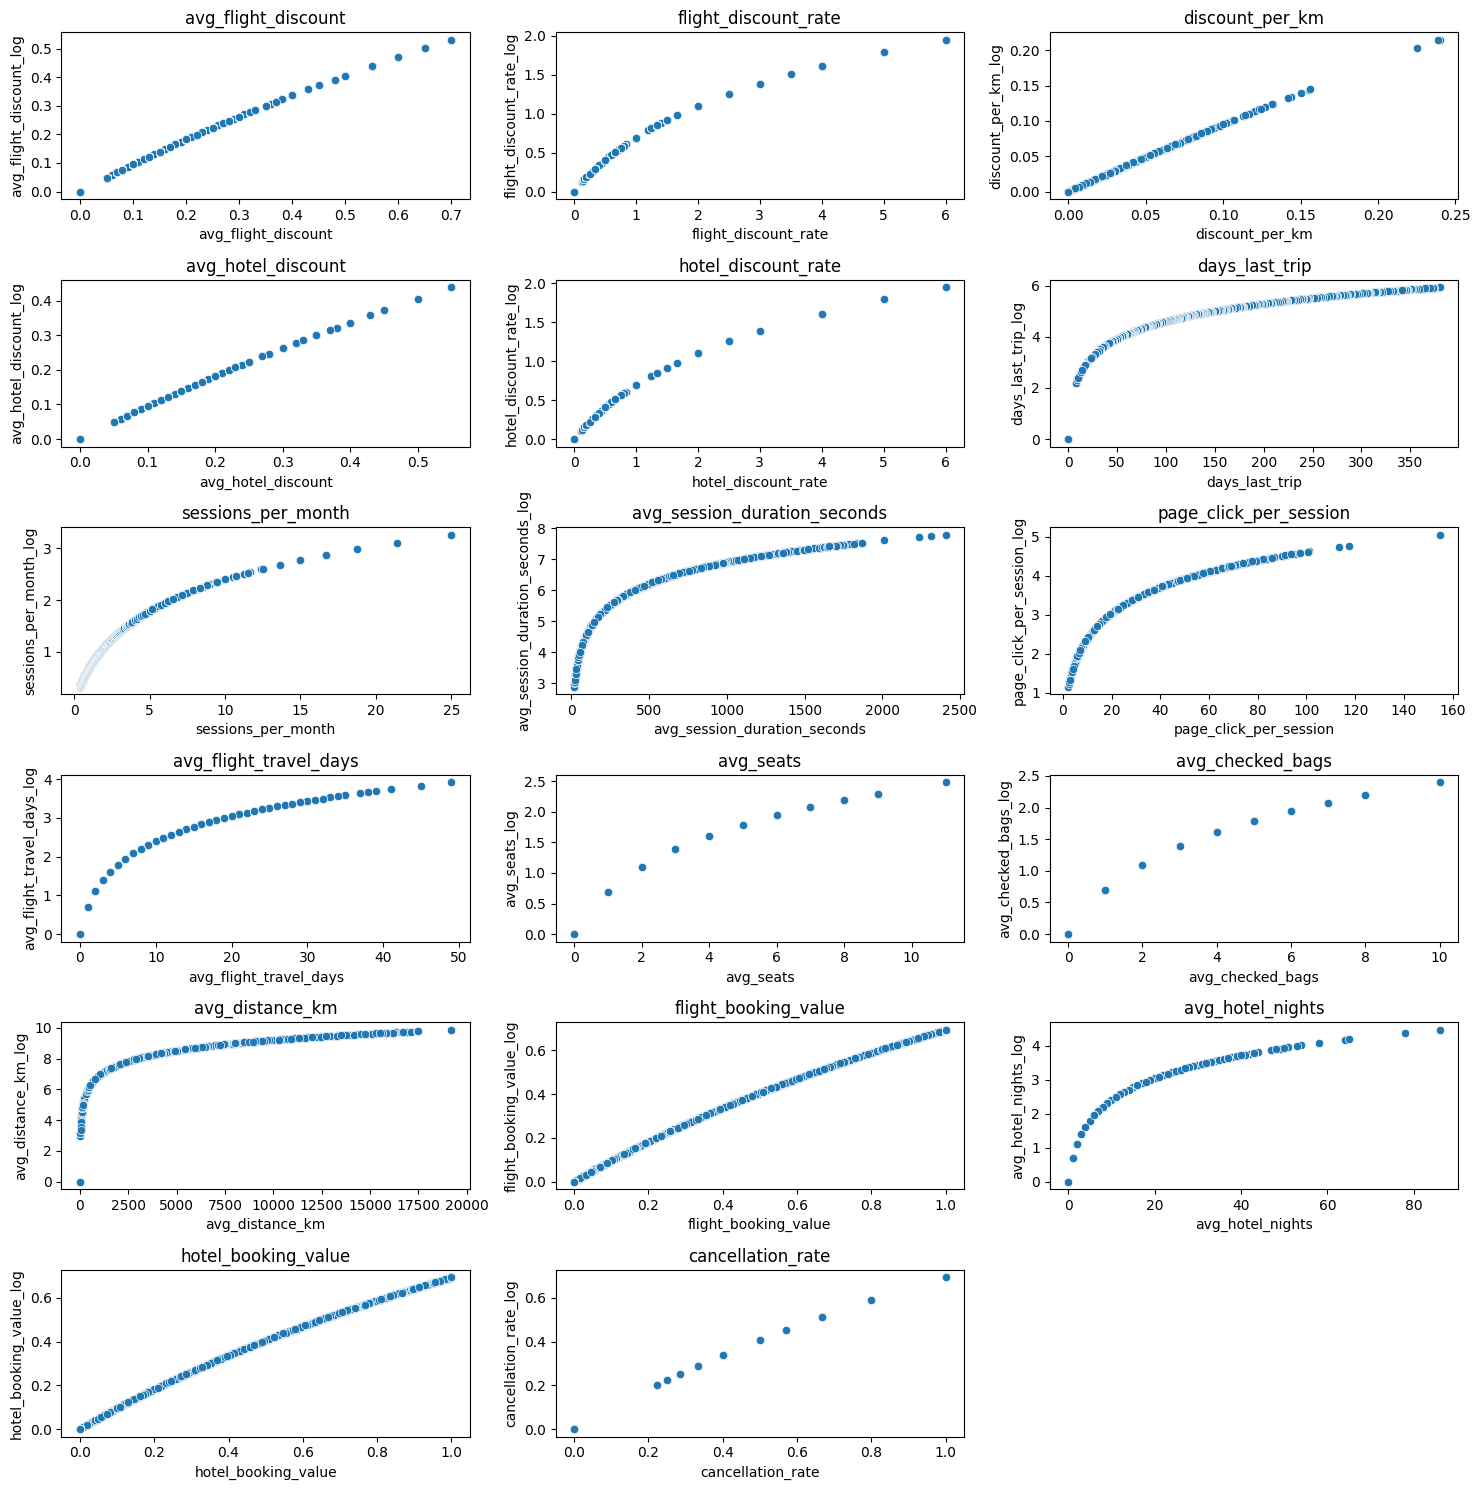

In [10]:
plot_utils.plot_relation_series(
    df=cohort,
    x=feature_names,
    y=log_names,
    n_cols=3,
    plot_type=sns.scatterplot,
    fig_height=15,
    fig_width=15,
)

### **Scaling features**

**scale log-transformed features, binary and approx. normal distributed features**

In [11]:
scale_names = []
feature_names = []
for feature in features:
    if feature in highly_skewed:
        feature_name = feature + "_log"
    else:
        feature_name = feature
    scale_name = feature + "_scaled"
    scale_names.append(scale_name)
    feature_names.append(feature_name)

In [12]:
feature_names

['avg_flight_discount_log',
 'flight_discount_rate_log',
 'discount_per_km_log',
 'avg_hotel_discount_log',
 'hotel_discount_rate_log',
 'age',
 'is_married',
 'has_children',
 'days_last_trip_log',
 'sessions_per_month_log',
 'avg_session_duration_seconds_log',
 'page_click_per_session_log',
 'avg_flight_travel_days_log',
 'avg_seats_log',
 'avg_checked_bags_log',
 'avg_distance_km_log',
 'flight_booked',
 'flight_booking_value_log',
 'avg_rooms',
 'avg_hotel_nights_log',
 'hotel_booked',
 'hotel_booking_value_log',
 'cancellation_rate_log']

**Apply `StandardScaler`:**  
subtracts mean from each observation, divided by standard deviation -> standardization (mean 0, std 1)
-> effect is centering the data

In [13]:
scaler = StandardScaler()
# for feature, score in zip(feature_names, score_names):
X_scaled = scaler.fit_transform(cohort[feature_names])
cohort[scale_names] = X_scaled

In [14]:
cohort[scale_names].agg(["mean", "std"]).round()

,avg_flight_discount_scaled,flight_discount_rate_scaled,discount_per_km_scaled,avg_hotel_discount_scaled,hotel_discount_rate_scaled,age_scaled,is_married_scaled,has_children_scaled,days_last_trip_scaled,sessions_per_month_scaled,avg_session_duration_seconds_scaled,page_click_per_session_scaled,avg_flight_travel_days_scaled,avg_seats_scaled,avg_checked_bags_scaled,avg_distance_km_scaled,flight_booked_scaled,flight_booking_value_scaled,avg_rooms_scaled,avg_hotel_nights_scaled,hotel_booked_scaled,hotel_booking_value_scaled,cancellation_rate_scaled
mean,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


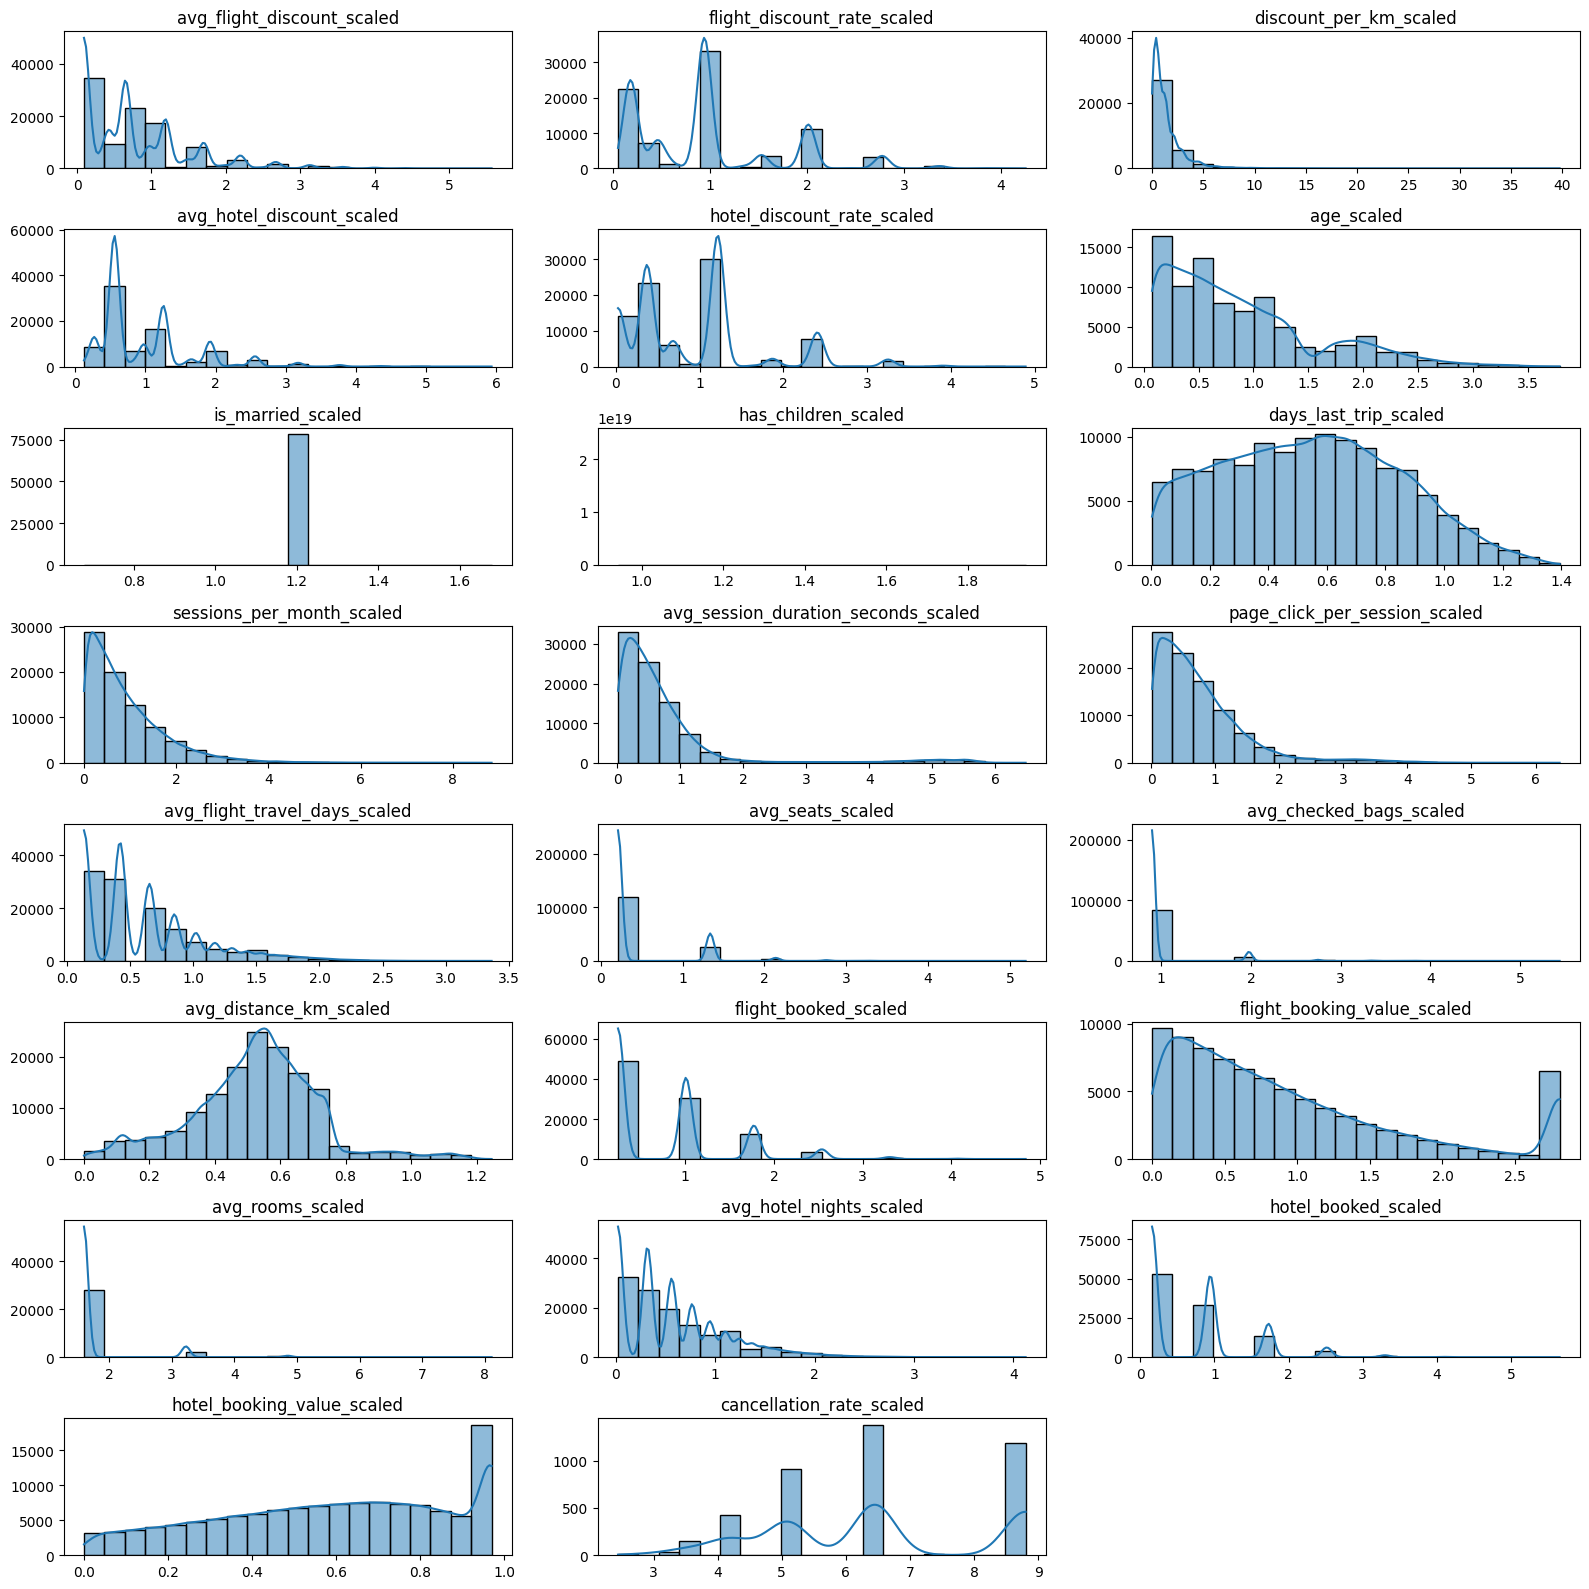

In [15]:
plot_utils.plot_univariate_series(
    df=cohort, metrics=list(scale_names), n_cols=3, plot_type=sns.histplot
)

**Apply PCA per thematic groups**

In [16]:
pca_info = {}
for score_name, features in feature_groups.items():
    features_scaled = [item + "_scaled" for item in features]
    cohort, pca_info[score_name] = preprocessing.apply_PCA(
        df=cohort, features=features_scaled, score_name=score_name, n_components=1
    )

**Explore PCA results**  
The goal of PCA (Principal Component Analysis) is to maximize the variance of the projected data (in this case, per feature group).  
The underlying assumption is that higher variance means more information.  
PCA identifies linear correlations between features and transforms the data into new, uncorrelated components, reducing redundancy.  

The **explained variance** shows how much of the total information (variance) is captured by each principal component.  
The **components** show how strongly each feature contributes to a principal component. This can be interpreted as follows:  
> 0.7 -> strong effect: the feature group is well represented by this component    
0.5 - 0.7 -> moderate effect: the feature contributes usefully, but less strongly   
< 0.5 -> weak contribution: the feature group is not well represented and may not be critical for the model (could be excluded or tested separately)

In [17]:
rows = []

for name, (variance, components) in pca_info.items():
    row = {
        "score_name": name,
        "explained_variance_ratio": variance[0],
    }
    rows.append(row)
    for i, val in enumerate(components):
        row[f"component_{i+1}"] = val

pd.DataFrame(rows).round(2).fillna("")

,score_name,explained_variance_ratio,component_1,component_2,component_3,component_4,component_5,component_6
0,flight_discount_score,0.57,0.59,0.61,0.52,,,
1,hotel_discount_score,0.78,0.71,0.71,,,,
2,user_score,0.48,0.68,0.71,0.17,,,
3,engagement_score,0.53,0.35,-0.26,0.63,0.64,,
4,flight_travel_score,0.65,0.45,0.46,0.31,0.48,0.37,0.34
5,hotel_travel_score,0.71,0.48,0.53,0.43,0.56,,
6,cancellation_score,1.00,1.00,,,,,


**Export original features, log-transformed, scaled features and scores from PCA**

In [21]:
db_utils.execute_sql(sql_filename="create_customer_features")

Successfully executed create_customer_features.sql


In [22]:
db_utils.write_df_to_db(df=cohort, tablename="customer_features")